In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

In [2]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *

In [3]:
import matplotlib.pyplot as plt
import time

# Load urdf 

In [4]:
from urdf_parser_py.urdf import URDF
from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE
from pkg.joint_utils import *
urdf_content = URDF.from_xml_file(URDF_PATH)

In [5]:
link_names = LINK_NAMES
base_name = LINK_NAMES[0]
joint_names = JOINT_NAMES
link_info_list = get_link_info_list(link_names, urdf_content)

# Visualize

In [6]:
from pkg.ros_rviz import *
pub, joints, rate = get_publisher(JOINT_NAMES)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


# Constraint

In [7]:
from pkg.geometry import *

In [8]:
def get_adjacent_links(link_name, urdf_content):
    adjacent_links = [link_name]
    for k, v in urdf_content.joint_map.items():
        if v.parent == link_name:
            adjacent_links += [v.child]
        if v.child == link_name:
            adjacent_links += [v.parent]
    return list(set(adjacent_links))

In [9]:
class ObjectLayer(layers.Layer):
    def __init__(self, gitem, N_sim, *args, **kwargs):
        self.gitem, self.N_sim = gitem, N_sim
        super(ObjectLayer, self).__init__(*args, **kwargs)
        
    def set_frame(self, Toff_list, link_idx_list, N_link):
        self.Toff_list = tf.constant(Toff_list) # (N_sim, 4,4)
        self.link_one_hot = tf.reshape(tf.one_hot(link_idx_list, N_link), (N_sim,N_link,1,1)) # (N_sim, N_link)
        
    # 변수를 만듭니다.
    def build(self, input_shape):
        pass

    # call 메서드가 그래프 모드에서 사용되면
    # training 변수는 텐서가 됩니다.
    @tf.function
    def call(self, input=None):
        T_all = input # (N_sim, N_link, 4,4)
        T_act = K.sum(T_all*self.link_one_hot, axis=1) # (N_sim, 4,4)
        T_bo = tf.matmul(T_act, self.Toff_list) # (N_sim, 4,4)
        return T_bo

# Graph

In [10]:
class GraphModel(tf.keras.Model):
    def __init__(self, robot_info, gitem_list, N_sim, alpha_jc=5, alpha_fc=200):
        super(GraphModel, self).__init__()
        self.alpha_jc = alpha_jc
        self.alpha_fc = alpha_fc
        self.robot_info = robot_info
        self.robot = RobotLayer(
            robot_info.link_info_list, rname = robot_info.rname, dim=N_sim)
        self.joint_constraint = JointConstraintLoss(self.robot)
        self.frame_constraint = FrameConstraintLoss()
        self.robot_base = [robot_info.base_frame]*N_sim
            
        self.object_dict = {}
        self.object_name_list = []
        for gitem in gitem_list:
            self.object_dict[gitem.name] = ObjectLayer(gitem, N_sim)
            self.object_name_list += [gitem.name]
            
    def assign_frame_dict(self, gframeset_list):
        frame_dict = {k: [] for k in self.object_dict.keys()}
        link_dict = {k: [] for k in self.object_dict.keys()}
        for gframeset in gframeset_list:
            for k, gframe in gframeset.items():
                frame_dict[k] += [gframe.Toff]
                link_dict[k] += [self.robot.link_name_list.index(gframe.link_name)]
        for k in frame_dict.keys():
            self.object_dict[k].set_frame(np.array(frame_dict[k]), np.array(link_dict[k]), self.robot.len_Q)
            
    def assign_Q(self, Q):
        self.robot.assign_Q(Q)
            
    def get_Q(self):
        return self.robot.get_Q()

    @tf.function
    def call(self, inputs=None):
        T_all = self.robot(self.robot_base)
        Tbo_all = []
        for obj_name in self.object_name_list:
            Tbo_all += [self.object_dict[obj_name](T_all)] #(Nobj,N_sim,4,4)
        Tbo_all = K.stack(Tbo_all, axis=1) #(N_sim,Nobj,4,4)
        return T_all, Tbo_all
    
    @tf.function
    def calc_loss(self, T_all, Tbo_all, Qtar, binQ, Ttar, binT):
        jc_loss = self.joint_constraint((Qtar, binQ))
        fc_loss = self.frame_constraint((T_all[:,-1,:,:],Ttar, binT))
        return self.alpha_jc*jc_loss+self.alpha_fc*fc_loss


In [11]:
N_sim = 50
N_joints = 9
DOF = 6
robot_info = RobotInfo(link_info_list, rname = "rbt1", base_frame=np.identity(4,dtype=np.float32))
gitem_list = [
    GeometryItem(name='box1', gtype=GeoType.BOX, dims=[0.1,0.1,0.1], color=(0,1,0,1), display=True, collision=True),
    GeometryItem(name='tool', gtype=GeoType.BOX, dims=[0.1,0.1,0.1], color=(0,1,0,1), display=True, collision=True),
]
gframe_dict = {"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,0,0)), "world"),
               "tool":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.0,0.0,0.1)), "tool0")
              }
marker_list = set_markers(gitem_list, gframe_dict, urdf_content)
graph = GraphModel(robot_info=robot_info, gitem_list=gitem_list, N_sim=N_sim)
optimizer = tf.optimizers.SGD(learning_rate=5e-3)

Please create a subscriber to the marker
publication OK - box1
publication OK - tool


In [15]:
Q_ = np.array([(0, 0,)+tuple((np.random.rand(DOF)*2-1)*np.pi)+(0,) for _ in range(N_sim)], dtype=np.float32)
Ttar = SE3(Rot_zyx(0,0,np.pi),(0.5,0,0)).astype(np.float32)
gframe_dict_list = [gframe_dict]*N_sim
graph.assign_Q(Q_)
graph.assign_frame_dict(gframe_dict_list)
time_vec = []
Q_list = [list(map(lambda x: x.numpy(), graph.get_Q()))]
Tbo_all_list = [np.array([[gframe_dict[gitem.name].Toff for gitem in gitem_list]]*N_sim)]
N_iter = 100
# Run training for the given number of steps.
for _ in range(N_iter):
    # Run the optimization to update W and b values.
    t1 = time.time()
    with tf.GradientTape() as g:
        # Forward pass.
        T_all, Tbo_all= graph(None)
        loss = graph.calc_loss(T_all, Tbo_all, 
                               np.zeros((N_sim, N_joints), dtype='float32'), np.zeros(N_sim, dtype='float32'),
                               np.array([Ttar]*N_sim), np.ones(N_sim, dtype='float32'))
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = graph.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
#     gradients = clip_gradient(gradients, 10)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    t2 = time.time()
    time_vec += [t2-t1]
    Q_list += [list(map(lambda x: x.numpy(), graph.get_Q()))]
    Tbo_all_list += [np.array(Tbo_all)]
print("mean {} ms".format(round(np.mean(time_vec)*1000,2)))
print("total {} ms".format(round(np.sum(time_vec)*1000,2)))
print("loss = {}".format(loss))

mean 4.51 ms
total 450.99 ms
loss = 1.9902868270874023


In [16]:
for i_sim in range(1): # N_sim):
    for i_iter in range(1,N_iter+1):
        q = Q_list[i_iter][i_sim]
        gframevec = [gframe_dict[gitem.name] for gitem in gitem_list]
        pose_list = [q[2:-1]]
        gframevec_list = [gframevec]
        show_motion(pose_list, marker_list, gframevec_list, pub, joints, error_skip=1e-6, period=1e-6)
        time.sleep(2e-2)

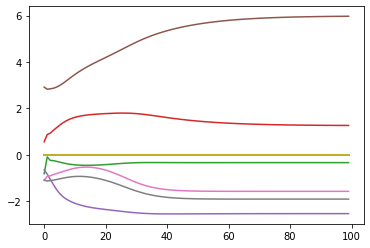

In [17]:
Q_all = np.array(Q_list)
Q_all_i = np.array([Q_all[i_iter, i_sim,:] for i_iter in range(N_iter)])
plt.plot(Q_all_i)

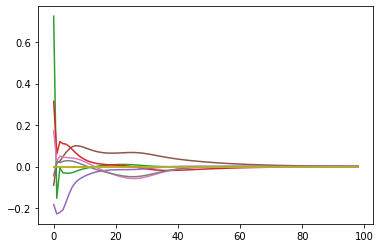

In [18]:
plt.plot(Q_all_i[1:,:]-Q_all_i[:-1,:])

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [11]:
import mpl_toolkits.mplot3d as mplot3d

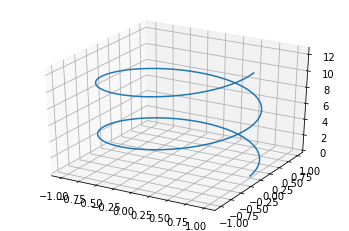

In [22]:
fig = plt.figure()
sub = fig.add_subplot(1,1,1,projection="3d")
sub.plot(x,y,z)
plt.show()

In [20]:
t = np.linspace(0,4*np.pi,500)
x = np.sin(t)
x = np.cos(t)
y = np.sin(t)
z = t